# Import libraries and functions

Import all necessary libraries.

In [33]:
import os
import sys
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [34]:
# Add the project root to the path to import model inference scripts
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

from src.models.ner_model.inference import infer_animal_from_text
from src.models.img_classification_model.inference import infer_class_from_image
from src.main import run_pipeline

Now time to ensure that directoties exist to import data without errors.

In [35]:
# Define critical paths
RAW_IMG_DATA_DIR = './src/data/img_data_raw'
CSV_IMG_DATA_DIR = './src/data/img_data_csv'
IC_TRAIN_MAP = os.path.join(CSV_IMG_DATA_DIR, 'img_data_train.csv')
IC_TEST_MAP = os.path.join(CSV_IMG_DATA_DIR, 'img_data_test.csv')

print(f"Raw data directory check: {'Exists' if os.path.isdir(RAW_IMG_DATA_DIR) else 'MISSING - Run data preparation first!'}")
print(f"IC Train Map check: {'Exists' if os.path.exists(IC_TRAIN_MAP) else 'MISSING - Run data preparation first!'}")

Raw data directory check: Exists
IC Train Map check: Exists


# Exploratory Data Analysis for Images Dataset

## Visualize Images

Visualize one image from a Squirrel class and print information about the image.

Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (770, 1024, 3) 



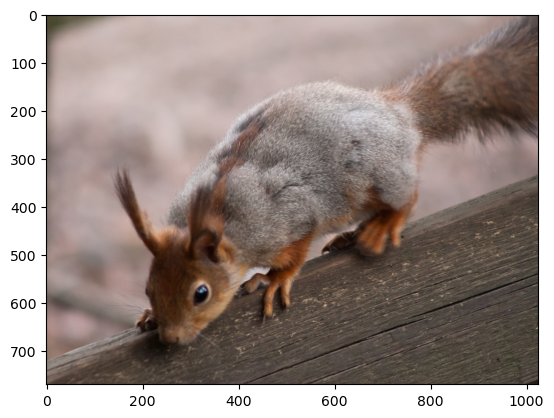

In [36]:
def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')

    plt.show()
    
   
example_image_path = os.path.join(RAW_IMG_DATA_DIR, 'Squirrel/Squirrel_0001.jpg')
display_image(example_image_path, print_info = True, hide_axis = False)

Visualize several random images from a dataset.

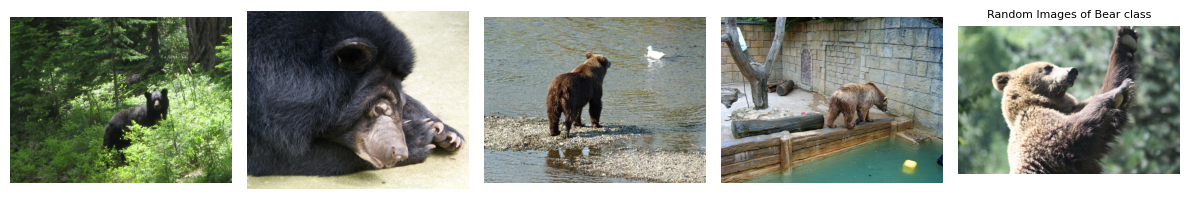

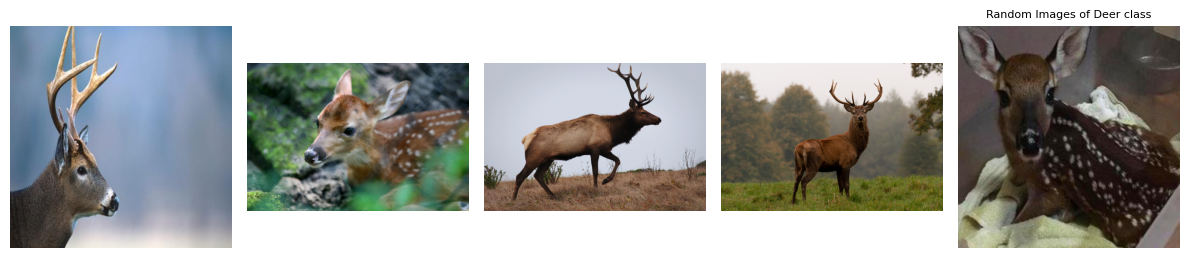

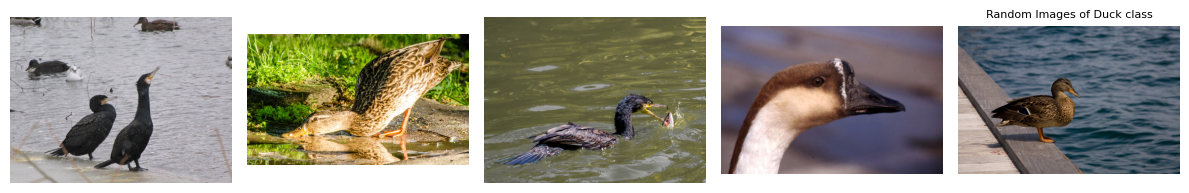

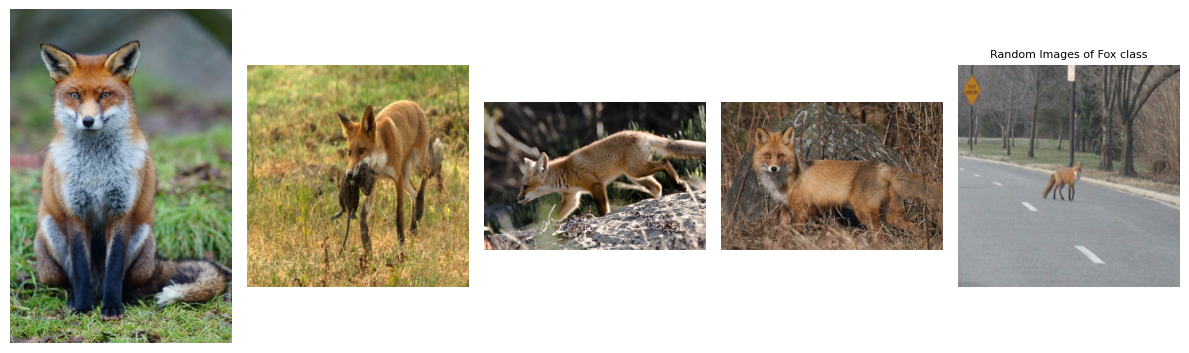

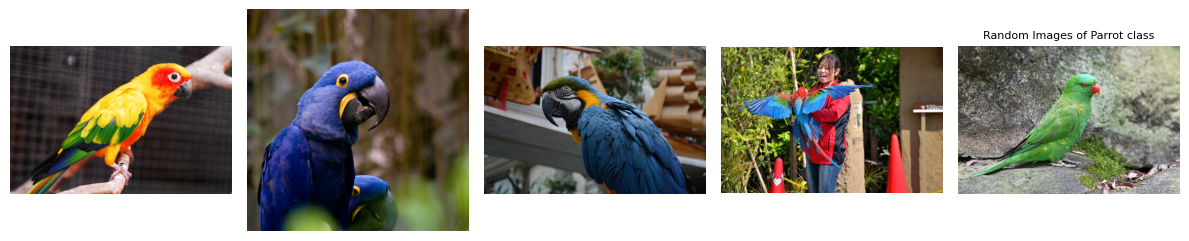

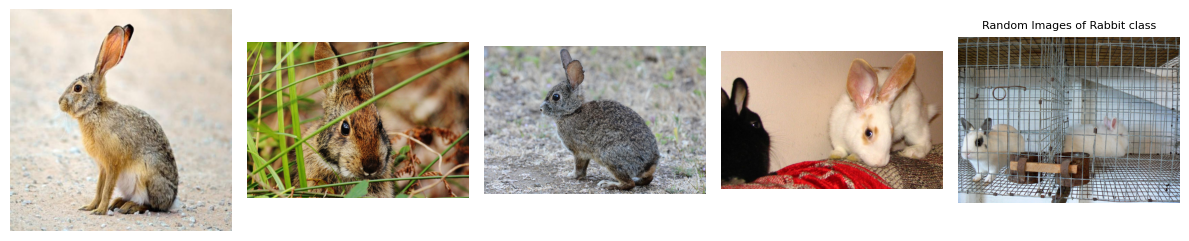

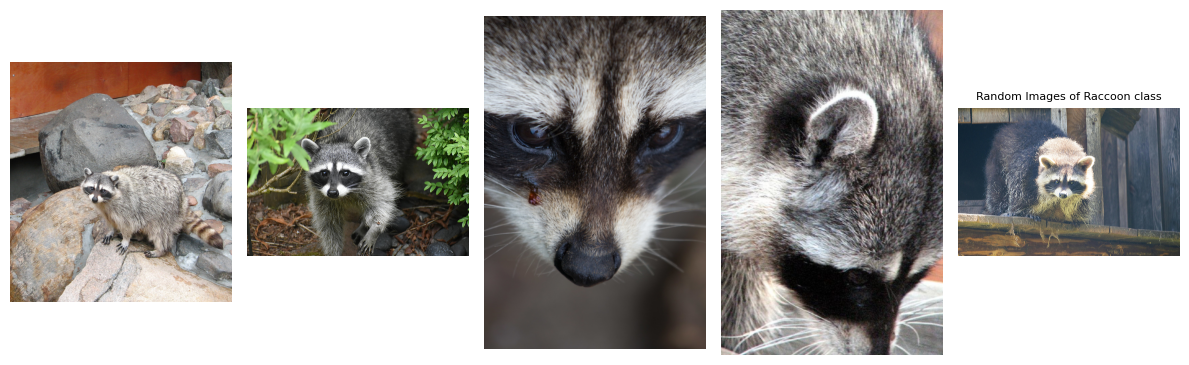

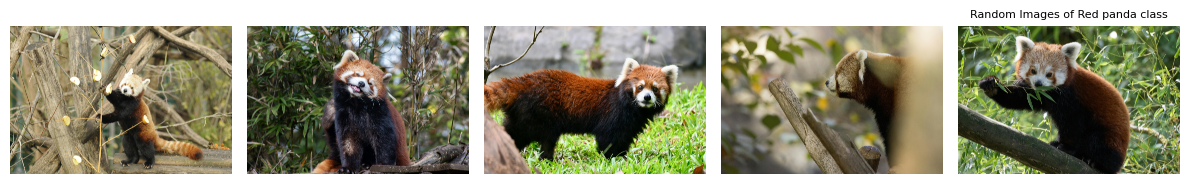

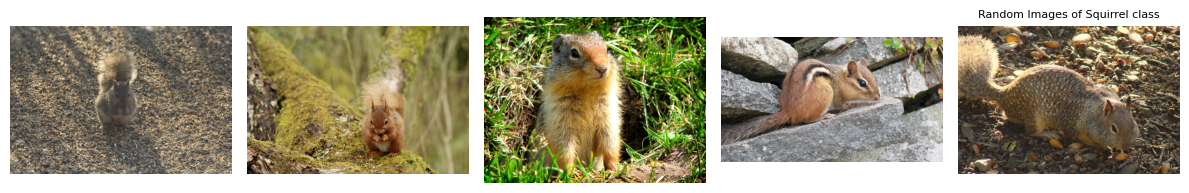

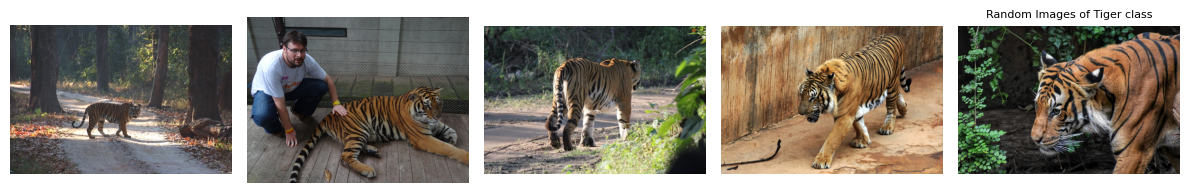

In [37]:
def plot_random_images_from_folder(folder_path, num_images=20, seed=42, class_name=None):
   
  random.seed(seed)

  # Get a list of image files in the folder
  image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]

  # Ensure that we have at least num_images files to choose from
  if len(image_files) < num_images:
    raise ValueError("Not enough images in the folder")

  # Randomly select num_images image files
  selected_files = random.sample(image_files, num_images)

  # Create a subplot grid
  num_cols = 5
  num_rows = (num_images + num_cols - 1) // num_cols
  fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

  for i, file_name in enumerate(selected_files):
    # Open and display the image using PIL
    img = Image.open(os.path.join(folder_path, file_name))
     
    if num_rows == 1:
      ax = axes[i % num_cols]
    else:
      ax = axes[i // num_cols, i % num_cols]
     
    ax.imshow(img)
    ax.axis('off')
    # ax.set_title(file_name)

  # Remove empty subplots
  for i in range(num_images, num_rows * num_cols):
    if num_rows == 1:
      fig.delaxes(axes[i % num_cols])
    else:
      fig.delaxes(axes[i // num_cols, i % num_cols])

  plt.tight_layout()
  plt.title(f'Random Images of {class_name} class', fontsize=8)
  plt.show()

for animal in ['Bear', 'Deer', 'Duck', 'Fox', 'Parrot', 'Rabbit', 'Raccoon', 'Red panda', 'Squirrel', 'Tiger']:
  plot_random_images_from_folder(os.path.join(RAW_IMG_DATA_DIR, animal), num_images=5 , seed=42, class_name=animal)

As it can be seen from the above images, the dataset contains clear images of animals with minimal background noise, but images can have different height and width.

## Load Data Map 

Loading the training and testing data mappings to inspect the distribution of classes.

In [38]:
if os.path.exists(IC_TRAIN_MAP) and os.path.exists(IC_TEST_MAP):
    df_train = pd.read_csv(IC_TRAIN_MAP)
    df_test = pd.read_csv(IC_TEST_MAP)
    
    print(f"Training Samples: {len(df_train)}")
    print(f"Testing Samples: {len(df_test)}")
    print("\nSample Training Data:")
    print(df_train.head())
else:
    print("Cannot perform EDA: Data map files are missing.")

Training Samples: 2869
Testing Samples: 1230

Sample Training Data:
                       filename class_label
0            Deer/Deer_0180.jpg        Deer
1            Bear/Bear_0170.jpg        Bear
2            Duck/Duck_0367.jpg        Duck
3            Bear/Bear_0140.jpg        Bear
4  Red panda/Red panda_0201.jpg   Red panda


## Visualize Class Distribution

A bar chart helps ensure that the classes are relatively balanced, which is important for good model performance.

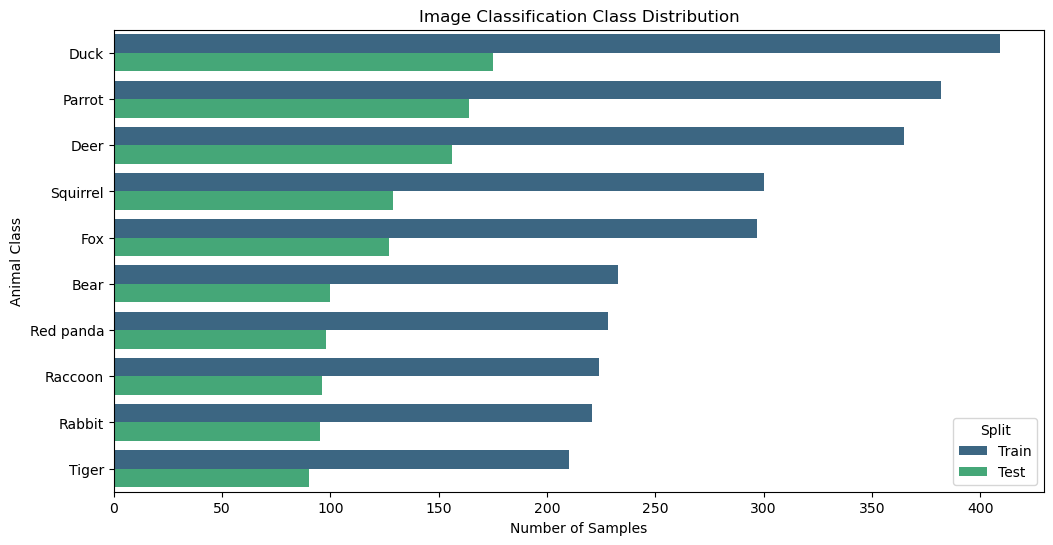

In [39]:
if 'class_label' in df_train.columns:
    plt.figure(figsize=(12, 6))
    
    # Combine train and test for a holistic view
    df_combined = pd.concat([df_train.assign(Split='Train'), df_test.assign(Split='Test')])
    
    sns.countplot(data=df_combined, y='class_label', hue='Split', order=df_combined['class_label'].value_counts().index, palette='viridis')
    
    plt.title('Image Classification Class Distribution')
    plt.xlabel('Number of Samples')
    plt.ylabel('Animal Class')
    plt.show()
else:
    print("Skipping visualization: 'label' column not found in data map.")

From the bar chart above, it can be seen that classes are not really balanced. For instance, number of samples for Duck class is twice bigger then number of samples for Tiger class that can badly influence on predictions for classes with fewer samples. Moreover, distribution in test dataset is the same as in train that is good for evaluation of the model.

# Pipeline Demo

This section is for demonstration full pipeline by using different cases.

In [40]:
# Define inputs for simulation
pipeline_text_1 = "I definitely see a rabbit in the pasture, it is large."
pipeline_image_path_1 = os.path.join(RAW_IMG_DATA_DIR, 'Rabbit/Rabbit_0016.jpg')

pipeline_text_2 = "That must be a horse over there."
pipeline_image_path_2 = os.path.join(RAW_IMG_DATA_DIR, 'Duck/Duck_0322.jpg')

pipeline_text_3 = "The ranger found a Red panda sleeping in the woods."
pipeline_image_path_3 = os.path.join(RAW_IMG_DATA_DIR, 'Red panda/Red panda_0273.jpg')

# Case 1: Perfect Match (Assuming IC predicts 'Rabbit' for mock_rabbit_path)
print("Running Test Case 1: Perfect Match (Rabbit)")
result_match = run_pipeline(
    text_message=pipeline_text_1,
    image_path=pipeline_image_path_1
)
print(f"\nResult (Match): {result_match}")

# Case 2: Mismatch (Assuming IC predicts 'Duck' for mock_duck_path)
print("\nRunning Test Case 2: Mismatch (Horse vs duck)")
result_mismatch = run_pipeline(
    text_message=pipeline_text_2,
    image_path=pipeline_image_path_2
)
print(f"\nResult (Mismatch): {result_mismatch}")

# Case 3: Multi-word entity Match (Assuming IC predicts 'Red panda' for a path)
print("\nRunning Test Case 3: Multi-word Entity Match")
result_multi = run_pipeline(
    text_message=pipeline_text_3,
    image_path=pipeline_image_path_3
)
print(f"\nResult (Multi-word Match): {result_multi}")

Running Test Case 1: Perfect Match (Rabbit)

--- Pipeline Output ---
Text Entity: 'rabbit' (Conf: 0.95)
Image Class: 'Rabbit' (Conf: 0.71)
Confidence Threshold Met: True
Match Found: True

Result (Match): True

Running Test Case 2: Mismatch (Horse vs duck)

--- Pipeline Output ---
Text Entity: 'horse' (Conf: 0.67)
Image Class: 'Duck' (Conf: 0.93)
Confidence Threshold Met: True
Match Found: False

Result (Mismatch): False

Running Test Case 3: Multi-word Entity Match

--- Pipeline Output ---
Text Entity: 'panda' (Conf: 0.73)
Image Class: 'Red panda' (Conf: 0.98)
Confidence Threshold Met: True
Match Found: False

Result (Multi-word Match): False


# Summary

So, after set up of the project and loading the dataset, Exploratory Data Analysis was done. As it can be seen, one of the main points was to check distribution of classes in train and test dataset and according to created bar chart the classes are relatively balanced, which is important for good model performance. Then, full pipeline demonstration was done by using different inputs. In result, pipeline worked as expected when animal mentioned in the text and image matched and mismatched, but when animal consist of 2 words (e.g. "Red panda") text recognition model was not able to find a match. So, each part of pipeline can be further optimized and reach even better performance. For future experiments can be done: augmentation of images; changing architecture of the model; change loss function to another one.